# Wstęp do Sztucznej Inteligencji - rok akademicki 2018/2019

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `{NrAlbumu}_{Nazwisko}_{Imie}_{PoprzedniaNazwa}`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia, w szczególności, że uzupełniłeś wszystkie pola `YOUR CODE HERE` oraz `YOUR ANSWER HERE`.

## Temat: Algorytmy genetyczne - Lab 3 - Zadania (obowiązkowe)
Zapoznaj się z treścią niniejszego notatnika czytając i wykonując go komórka po komórce. Wykonaj napotkane zadania/ćwiczenia.

## Zadanie 1 (1pkt.)

Zgodnie z instrukcjami prowadzącego, wybierz funkcję testową ze strony: https://www.sfu.ca/~ssurjano/optimization.html z działu "Many Local Minima" (z wyjątkiem funkcji nr 6).

Zaplementuj ją jako funkcję w Pythonie.

Dla wszystkich funkcji przyjmujemy `N=2` tzn. rozważamy ją jako funkcję dwóch zmiennych $f(x_1, x_2)$.

In [318]:
nr_albumu = 125698
nr_albumu % 16 + 1

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import genetic_utils as gu # własne implementacje funkcji z poprzednich zadan
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def obj_func(x: np.ndarray):
    """Testowa funkcja celu:
    https://www.sfu.ca/~ssurjano/crossit.html
    Argumenty:
    x - jednowymiarowa, dwuelementowa tablica ndarray"""

    x1 = x[0]
    x2 = x[1]

    exp_arg = 100 - math.sqrt(x1 ** 2 + x2 ** 2) / math.pi
    exp_arg = math.fabs(exp_arg)
    in_bracket = math.sin(x1) * math.sin(x2) * math.exp(exp_arg)
    in_bracket = math.fabs(in_bracket) + 1
    
    return -(-0.0001 * in_bracket ** 0.1)


## Zadanie 2 (1pkt.)

Przygotuj wykres 3D funkcji zaimplementowanej w zadaniu nr 1.

<IPython.core.display.Javascript object>


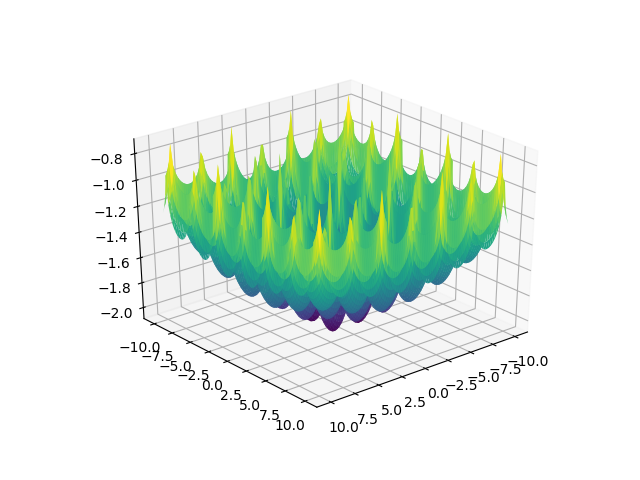

In [5]:
def plot_func(obj_func, just_data=False):
    xs = np.linspace(-10, 10, 100)
    ys = np.linspace(-10, 10, 100)
    xs, ys = np.meshgrid(xs, ys)
    zs = np.array([obj_func(arg) for arg in zip(np.ravel(xs), np.ravel(ys))])
    zs = zs.reshape(xs.shape)
    
    params = (xs, ys, -zs)
    kwargs = {'rstride':1, 'cstride':1, 'linewidth':0.4, 'antialiased':True}
    if just_data:
        return params, kwargs
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(*params, **kwargs, cmap='viridis', alpha=1.0)
    ax.view_init(30, 50)

    
plot_func(obj_func)

## Zadanie 3 (2pkt.)

Korzystając z funkcji zaimplementowanych na poprzednich zajęciach, zaimplementuj główną pętlę klasycznego algorytmu genetyczengo.
![pag_schemat.png](http://torus.uck.pk.edu.pl/~amarsz/images/pag_schemat.png)

Implementacja powinna mieć postać funkcji, która przyjmuje parametry:

- `fun` - funkcja, której maksimum ma zostać znalezione
- `pop_size` - rozmiar populacji
- `pk` - prawdopodobieństwo krzyżowania
- `pm` - prawdopodobieństwo mutacji
- `generations` - liczba pokoleń 
- `dx` - dokładność kodowania

Funkcja powinna zwracać:
- `best_sol` - najlepsze znalezione rozwiązanie (nieważne, w której iteracji; UWAGA! niekoniecznie jest to najlepszy osobnik z ostatniej populacji)
- `best_generation` - numer pokolenia, z którego pochodzi najlepsze rozwiązanie
- `list_best` - lista z najlepszą oceną osobnika w każdym pokoleniu (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
- `list_best_generation` - lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
- `list_mean` - lista z wartościami średnimi ocen osobników z każdego pokolenia

In [7]:
def plot_function_with_populations(start_pop, middle_pop, end_pop):
    plt.close()
    
    params, kwargs = plot_func(obj_func, True)    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(*params, **kwargs, cmap='pink', alpha=0.2)
    
    ax.scatter(-np.take(start_pop['decoded'], 0, axis=1),
               -np.take(start_pop['decoded'], 1, axis=1), 
               -start_pop['evaluated'],
               label='First generation', c='r',
               alpha=1)
    ax.scatter(-start_pop['best'][0][0],
               -start_pop['best'][0][1], 
               -start_pop['best'][1],
               label='First max', c='c', marker='x', s=2**8,
               alpha=1)
    
    ax.scatter(-np.take(middle_pop['decoded'], 0, axis=1),
               -np.take(middle_pop['decoded'], 1, axis=1), 
               -middle_pop['evaluated'],
               label='Middle generation', c='g',
               alpha=1)
    ax.scatter(-middle_pop['best'][0][0],
               -middle_pop['best'][0][1], 
               -middle_pop['best'][1],
               label='Middle max', c='m', marker='x', s=2**8,
               alpha=1)
    
    ax.scatter(-np.take(end_pop['decoded'], 0, axis=1),
               -np.take(end_pop['decoded'], 1, axis=1), 
               -end_pop['evaluated'],
               label='Last generation', c='b',
               alpha=1)
    ax.scatter(-end_pop['best'][0][0],
               -end_pop['best'][0][1], 
               -end_pop['best'][1],
               label='Last max', c='k', marker='x', s=2**8,
               alpha=1)
    
    ax.legend()
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Value')
    plt.show()    
    
    
def plot_results(list_best, list_best_generation, list_mean):
    t1 = np.arange(0, len(list_best), 1)

    fig = plt.figure(2)
    ax = fig.add_subplot(111)
    line1, = plt.plot(t1, list_best, 'r-')
    line2, = plt.plot(t1, list_best_generation, 'g-')
    line3, = plt.plot(t1, list_mean, 'b-')

    ax.set_xlabel('numer generacji')
    ax.set_ylabel('wartość funkcji')
    plt.legend((line1, line2, line3), ('list_best', 'list_best_generation', 'list_mean'))
    plt.show()


def genetic_algorithm(func,
                      population_size: int,
                      crossing_probability: float,
                      mutation_probability: float,
                      generations: int,
                      dx: float,
                      make_plots=False):
    """Argumenty:
    func - funkcja, której maksimum ma zostać znalezione
    population_size - rozmiar populacji
    crossing_probability - prawdopodobieństwo krzyżowania
    mutation_probability - prawdopodobieństwo mutacji
    generations - liczba pokoleń
    dx - dokładność kodowania
    make_plots - jeśli True to wygeneruje wykresy z matplotlib

    Zwraca słownik:
    best_sol - najlepsze znalezione rozwiązanie (globalne)
    best_generation - numer pokolenia, z którego pochodzi najlepsze rozwiązanie
    list_best - lista z najlepszą oceną osobnika w każdym pokoleniu
        (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
    list_best_generation - lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
    list_mean - lista z wartościami średnimi ocen osobników z każdego pokolenia"""

    func_options = {
        'n_dim': 2,
        'x1_start': -10,
        'x1_end': 10,
        'x2_start': -10,
        'x2_end': 10,
    }

    var_num_bits, dx = gu.nbits(func_options['x1_start'], func_options['x2_end'], dx)

    # losowa populacja początkowa
    population = gu.gen_population(population_size, func_options['n_dim'], var_num_bits)

    # ocena wszystkich osobników populacji
    population_eval = gu.evaluate_population(func,
                                             population,
                                             func_options['n_dim'],
                                             var_num_bits,
                                             func_options['x1_start'],
                                             dx)

    # najlepsze rozwiazanie: tuple(osobnik, wartosc funkcji dopasowania)
    best_sol_global = gu.get_best(population, population_eval)

    if make_plots:
        middle_generation_index = np.floor(generations/2)
        last_generation_index = generations - 1
        start_pop = {
            "decoded": np.apply_along_axis(gu.decode_individual, 1, population,
                                func_options['n_dim'], var_num_bits,
                                func_options['x1_start'], dx),
            "evaluated": np.copy(population_eval),
            "best": (
                gu.decode_individual(best_sol_global[0],
                                     func_options['n_dim'], var_num_bits,
                                     func_options['x1_start'], dx),
                best_sol_global[1]
            )
        }

    list_best = np.zeros(generations)
    list_best_generation = np.zeros(generations)
    list_mean = np.zeros(generations)

    best_generation = 0
    list_best[0] = best_sol_global[1]
    list_best_generation[0] = best_sol_global[1]
    list_mean[0] = np.mean(population_eval)

    # główna pętla algorytmu
    for i in range(generations):
        # selekcja
        population = gu.roulette(population, population_eval)
        # krzyzowanie
        population = gu.cross(population, crossing_probability)
        # mutacja
        population = gu.mutate(population, mutation_probability)
        # ocena
        population_eval = gu.evaluate_population(func,
                                                 population,
                                                 func_options['n_dim'],
                                                 var_num_bits,
                                                 func_options['x1_start'],
                                                 dx)

        # zapisanie danych
        best_sol_current = gu.get_best(population, population_eval)
        list_best_generation[i] = best_sol_current[1]
        list_mean[i] = np.mean(population_eval)

        if best_sol_current[1] > best_sol_global[1]:
            best_generation = i + 1
            best_sol_global = best_sol_current

        list_best[i] = best_sol_global[1]

        if make_plots:
            if i == middle_generation_index:
                middle_pop = {
                    "decoded": np.apply_along_axis(gu.decode_individual, 1, population,
                                                   func_options['n_dim'], var_num_bits,
                                                   func_options['x1_start'], dx),
                    "evaluated": np.copy(population_eval),
                    "best": (
                        gu.decode_individual(best_sol_global[0],
                                             func_options['n_dim'], var_num_bits,
                                             func_options['x1_start'], dx),
                        best_sol_global[1]
                    )
                }
            if i == last_generation_index:
                end_pop = {
                    "decoded": np.apply_along_axis(gu.decode_individual, 1, population,
                                                   func_options['n_dim'], var_num_bits,
                                                   func_options['x1_start'], dx),
                    "evaluated": np.copy(population_eval),
                    "best": (
                        gu.decode_individual(best_sol_global[0],
                                             func_options['n_dim'], var_num_bits,
                                             func_options['x1_start'], dx),
                        best_sol_global[1]
                    )
                }
                
    if make_plots:
        plot_function_with_populations(start_pop, middle_pop, end_pop)

    return {
        'best_sol': best_sol_global[1], 
        'best_generation': best_generation, 
        'list_best': list_best,
        'list_best_generation': list_best_generation, 
        'list_mean': list_mean
    }


## Zadnie 4 (1pkt.)

Zaprezentuj działanie algorytmu z przykładowymi wartościami parametrów:

- `pop_size`: 60
- `pk`: 0.7
- `pm`: 0.01
- `generations`: 200
- `dx`: 1e-10

Na wykresach funkcji 3D przedstaw położenie osobników z pierwszej populacji, w połowie ewolucji oraz końcowej populacji. Zaznacz wyraźnie położenie najlepszeg rozwiązania.

Na wykresach 2D przedstaw przebieg wartości z list z zebranymi statystykami (listy `list_best`, `list_best_generation`, `list_mean`) w zależności od numeru pokolenia. 

<IPython.core.display.Javascript object>


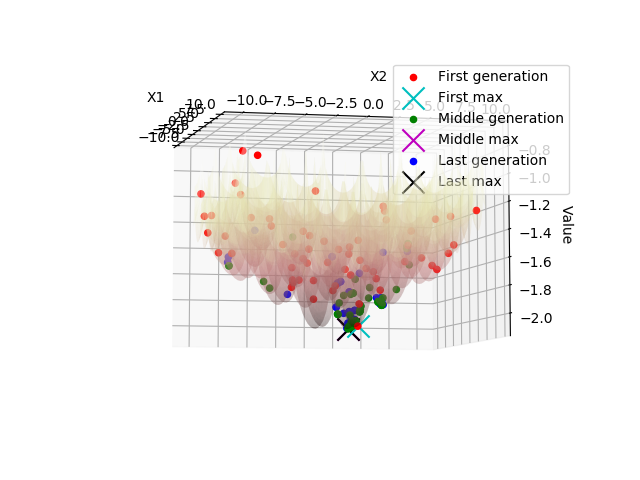

<IPython.core.display.Javascript object>


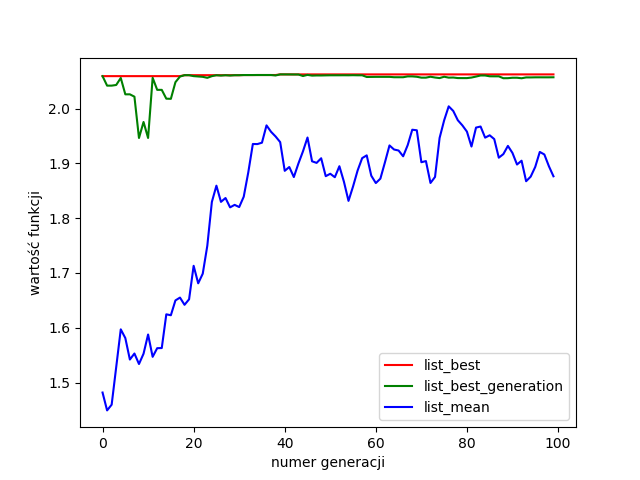

In [17]:
result = genetic_algorithm(obj_func, 60, 0.7, 0.01, 100, 1e-10, make_plots=True)
plot_results(result['list_best'], result['list_best_generation'], result['list_mean'])

## Zadanie 5 (5pkt.)

Zbadaj wpływ parametrów klasycznego algorytmu genetycznego na jego zdolność znalezienia optymalnego rozwiązania. Dla ułatwienia analizy, zmieniając jeden parametr, zachowaj typowe wartości pozostałych.

1. Jak działa algorytm z typowymi ustawieniami parametrów (jak w zadaniu 4)? Podaj średnią wartość przystosowania znalezionego rozwiązania po wielokrotnym uruchomieniu AG.
2. Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"? Porównaj zarówno jak dobre rozwiązanie zostało znalezione jak również w której generacji.
    - `generations`: kilka różnych wartości z przedziału [100, 10000]
3. Czy mutacja jest potrzebna? 
    - `pm` = 0.0
4. Jak działa algorytm bez krzyżowania, z samą mutacją? 
    - `pk` = 0.0
5. Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą, jeśli liczba ewaluacji funkcji jest taka sama (np. 2000)?
    - porównaj dwa ustawienia: `pop_size`=20, `generations`=100  vs. `pop_size`=100, `generations`=20.

UWAGA: Powyższe porównania powinny być wykonane na podstawie uśrednionych wyników co najmniej 10 uruchomień algorytmu z danymi parametrami. Podając wyniki podaj średnią z najlepszych znalezionych rozwiązań oraz odchylenie standardowe oraz numer pokolenia, w którym znaleziono rozwiązanie.

In [18]:
import time


exec_num = 20


def print_header(func, input_data, input_data2=None):
    if input_data2:
        print('\n', func.__name__,
              '_' * len(func.__name__),
              func.__doc__,
              input_data,
              input_data2, '\n',
              sep='\n')
    else:
        print('\n', func.__name__,
              '_' * len(func.__name__),
              func.__doc__,
              input_data, '\n',
              sep='\n')


def zadanie_1(print_data=False, inputs=None):
    """Jak działa algorytm z typowymi ustawieniami parametrów?"""
    if not inputs:
        inputs = {
            'population_size': 60,
            'crossing_probability': 0.7,
            'mutation_probability': 0.01,
            'generations': 200,
            'dx': 1e-10
        }
        print_header(zadanie_1, inputs)

    solutions = np.empty(exec_num)
    in_which_generation = np.empty(exec_num)

    print('Liczę...')
    time_start = time.time()

    for i in range(exec_num):
        result = genetic_algorithm(obj_func, **inputs)
        solutions[i] = result['best_sol']
        in_which_generation[i] = result['best_generation']

    time_end = time.time()
    print('\rPoliczenie tego zajęło mi {0} s\n'.format(round(time_end - time_start, 3)))

    if print_data:
        print('Wszystkie rozwiazania:\n', solutions)
        print('Wszystkie nr pokoleń:\n', in_which_generation)

    print('Średnia wartość znalezionego rozwiązania: ',
          np.average(solutions))
    print('Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie: ',
          np.average(in_which_generation))
    print('Odchylenie standardowe znalezionych rozwiązań',
          np.std(solutions))
    print('Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie: ',
          np.std(in_which_generation))


def zadanie_2(gen_vals_how_many, gen_vals_start, gen_vals_stop, print_data=False):
    """Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"?"""
    inputs = {
        'population_size': 60,
        'crossing_probability': 0.7,
        'mutation_probability': 0.01,
        'generations': None,
        'dx': 1e-10
    }
    print_header(zadanie_2, inputs)

    generations_values = np.linspace(gen_vals_start, gen_vals_stop, gen_vals_how_many, dtype=int)
    solutions = np.empty(shape=(exec_num, gen_vals_how_many))
    in_which_generation = np.empty(shape=(exec_num, gen_vals_how_many))

    print('Liczę...')
    time_start = time.time()

    for i in range(exec_num):
        for j in range(gen_vals_how_many):
            inputs['generations'] = generations_values[j]
            result = genetic_algorithm(obj_func, **inputs)
            solutions[i][j] = result['best_sol']
            in_which_generation[i][j] = result['best_generation']

    time_end = time.time()
    print('\rPoliczenie tego zajęło mi {0} s\n'.format(round(time_end - time_start, 3)))

    if print_data:
        print('Wszystkie rozwiazania:\n', solutions)
        print('Wszystkie nr pokoleń:\n', in_which_generation)

    avg_solutions = np.average(solutions, axis=0)
    print('Średnie wartości znalezionych rozwiązań: ')
    for gens_amount, sol in zip(generations_values, avg_solutions):
        print('Pokoleń: {0} średnio: {1}'.format(gens_amount, sol))

    avg_which_gen = np.average(in_which_generation, axis=0)
    print('Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie: ')
    for gens_amount, which in zip(generations_values, avg_which_gen):
        print('Pokoleń: {0} średnio: {1}'.format(gens_amount, which))

    std_solutions = np.std(solutions, axis=0)
    print('Odchylenie standardowe znalezionych rozwiązań')
    for gens_amount, dev in zip(generations_values, std_solutions):
        print('Pokoleń: {0} odchylenie: {1}'.format(gens_amount, dev))

    std_which_gen = np.std(in_which_generation, axis=0)
    print('Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie: ')
    for gens_amount, dev in zip(generations_values, std_which_gen):
        print('Pokoleń: {0} odchylenie: {1}'.format(gens_amount, dev))


def zadanie_3(print_data=False):
    """Czy mutacja jest potrzebna?"""
    inputs = {
        'population_size': 60,
        'crossing_probability': 0.7,
        'mutation_probability': 0.0,
        'generations': 200,
        'dx': 1e-10
    }
    print_header(zadanie_3, inputs)
    zadanie_1(print_data, inputs)


def zadanie_4(print_data=False):
    """Jak działa algorytm bez krzyżowania, z samą mutacją?"""
    inputs = {
        'population_size': 60,
        'crossing_probability': 0.0,
        'mutation_probability': 0.01,
        'generations': 200,
        'dx': 1e-10
    }
    print_header(zadanie_4, inputs)
    zadanie_1(print_data, inputs)


def zadanie_5(print_data=False):
    """Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą?"""
    inputs1 = {
        'population_size': 20,
        'crossing_probability': 0.0,
        'mutation_probability': 0.01,
        'generations': 100,
        'dx': 1e-10
    }
    inputs2 = {
        'population_size': 100,
        'crossing_probability': 0.0,
        'mutation_probability': 0.01,
        'generations': 20,
        'dx': 1e-10
    }
    print_header(zadanie_5, inputs1, inputs2)
    zadanie_1(print_data, inputs1)
    print('\n')
    zadanie_1(print_data, inputs2)


# zadanie_1()
# zadanie_2(5, 100, 10000)
# zadanie_3()
# zadanie_4()
# zadanie_5()

UMIEŚĆ TWOJE WNIOSKI I KOMENTARZE W KOMÓRCE PONIŻEJ

Odnieś się do każdego punktu.

zadanie_1
_________
Jak działa algorytm z typowymi ustawieniami parametrów?

{'population_size': 60, 'crossing_probability': 0.7, 'mutation_probability': 0.01, 'generations': 200, 'dx': 1e-10}


Liczę...
Policzenie tego zajęło mi 32.45 s

Średnia wartość znalezionego rozwiązania:  2.0622914729379636
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie:  103.0
Odchylenie standardowe znalezionych rozwiązań 0.0007016353991034988
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie:  53.558379363083795


zadanie_2
_________
Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"?
{'population_size': 60, 'crossing_probability': 0.7, 'mutation_probability': 0.01, 'generations': None, 'dx': 1e-10}


Liczę...
Policzenie tego zajęło mi 4960.339 s

Średnie wartości znalezionych rozwiązań: 
Pokoleń: 100 średnio: 2.0621171079165053
Pokoleń: 2575 średnio: 2.0626099925654366
Pokoleń: 5050 średnio: 2.062610473666754
Pokoleń: 7525 średnio: 2.0626110624333385
Pokoleń: 10000 średnio: 2.0626114768020187
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie: 
Pokoleń: 100 średnio: 59.85
Pokoleń: 2575 średnio: 1571.6
Pokoleń: 5050 średnio: 2760.8
Pokoleń: 7525 średnio: 4401.35
Pokoleń: 10000 średnio: 4338.15
Odchylenie standardowe znalezionych rozwiązań
Pokoleń: 100 odchylenie: 0.0007553814234669377
Pokoleń: 2575 odchylenie: 1.680920986778839e-06
Pokoleń: 5050 odchylenie: 1.4614126446069447e-06
Pokoleń: 7525 odchylenie: 8.078835595908257e-07
Pokoleń: 10000 odchylenie: 5.297806548239155e-07
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie: 
Pokoleń: 100 odchylenie: 21.60387696687796
Pokoleń: 2575 odchylenie: 691.5445321886365
Pokoleń: 5050 odchylenie: 1421.654233630667
Pokoleń: 7525 odchylenie: 2236.0406587314105
Pokoleń: 10000 odchylenie: 3389.392855291343


zadanie_3
_________
Czy mutacja jest potrzebna?
{'population_size': 60, 'crossing_probability': 0.7, 'mutation_probability': 0.0, 'generations': 200, 'dx': 1e-10}


Liczę...
Policzenie tego zajęło mi 33.503 s

Średnia wartość znalezionego rozwiązania:  2.0506139201945413
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie:  18.5
Odchylenie standardowe znalezionych rozwiązań 0.014623569212963795
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie:  19.655787951644168


zadanie_4
_________
Jak działa algorytm bez krzyżowania, z samą mutacją?
{'population_size': 60, 'crossing_probability': 0.0, 'mutation_probability': 0.01, 'generations': 200, 'dx': 1e-10}


Liczę...
Policzenie tego zajęło mi 32.037 s

Średnia wartość znalezionego rozwiązania:  2.062170396099354
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie:  127.8
Odchylenie standardowe znalezionych rozwiązań 0.0005783322718491937
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie:  54.531275429793496


zadanie_5
_________
Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą?
{'population_size': 20, 'crossing_probability': 0.0, 'mutation_probability': 0.01, 'generations': 100, 'dx': 1e-10}
{'population_size': 100, 'crossing_probability': 0.0, 'mutation_probability': 0.01, 'generations': 20, 'dx': 1e-10}


Liczę...
Policzenie tego zajęło mi 5.442 s

Średnia wartość znalezionego rozwiązania:  2.054364594265237
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie:  62.45
Odchylenie standardowe znalezionych rozwiązań 0.01299010494492956
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie:  28.61201670627221


Liczę...
Policzenie tego zajęło mi 5.828 s

Średnia wartość znalezionego rozwiązania:  2.057504796979584
Średni numer pokolenia, w którym znaleziono najelpsze rozwiązanie:  13.1
Odchylenie standardowe znalezionych rozwiązań 0.004525144410676211
Odchylenie standardowe numerów pokoleń, w których znaleziono najelpsze rozwiązanie:  5.61159513863928

# Podsumowanie i wnioski
## Pytanie 1
Algorytm daje zadowalające rezultaty, średnio rozwiązanie ma dokładność rzędu 1e-3 przy niewielkim rozrzucie uzyskanych najlepszych rozwiązań. Średnio najlepsze rozwiązanie było uzyskiwane w połowie ewolucji, z odchyleniem równym około 1/4 ilości generacji.
## Pytanie 2
Wraz ze wzrostem ilości pokoleń dokładność rozwiązania wzrasta, jednakże nieliniowo i są to wartości rzędu czwartego miejsca po przecinku; odchylenie tych wartości również maleje z podonym  trendem. Tendencja do znajdywania najlepszego rozwiązania w okolicach połowy procesu ewolucji jest utrzymana niezależnie od ilości pokoleń. Podobnie z miarą rozrzutu wokół średniej tych wartości; odchylenie standardowe przyjmuje wartości w okolicach 1/4 ilości pokoleń.
Można zatem wysnuć wniosek, że używanie algorytmu z dużą ilością pokoleń (typu 2500) jest nieopłacalne pod względem czasu obliczeń.
## Pytanie 3
Przy braku mutacji, najlepsze rozwiązanie jest odnajdywane stosunkowo szybko. Jednakże dokładność tego rozwiązania jest zauważalnie mniejsza niż w próbie kontrolnej. Zatem jeśli szybka zbieżność przy jednoczesny braku potrzeby bardzo dokładnego rozwiązania jest porządana, zastosowanie małego prawdopodobieństwa mutacji może być odpowiednią strategią.
## Pytanie 4
W przyoadku braku krzyżowania zauważalna jest odwrotna tendencja niż przy braku mutacji. Mianowicie rozwiązanie jest stosunkowo dobre (rzędu 1e-3) natomiast zbieżność algorytmu do tego rozwiązania jest wydłużona w kierunku końca procesu ewolucji.
## Pytanie 5
W obu przypadkach dostajemy podobną dokładność rozwiązania, średnią ilość pokoleń z najlepszym rozwiązaniem i odpowiadające jej odchylenie standardowe. Jednakże większa populacja, która krócej ewoluowała cechowała się mniejszym rozrzutem najelpszych rozwiązań globalnych. Zatem ta strategia wychodzi na prowadzenie względem strategi długiego procesu ewolucji małej populacji.
Idę spać.

<div style="text-align: right">&copy; Zakład Inteligencji Obliczeniowej, Instytut Informatyki, Politechnika Krakowska </div>